## Nanophotonic natural language processing

In [1]:
width, depth = 4, 2  # width and depth of the piece of chip for one word

n_photons = 2
input_modes = output_modes = [0, 1, 1, 0]

bias, weight = -0.7, 5  # bias and weight for the classical post-processing

n_iter, alpha, gamma = 100, 0.602, 0.101  # optimization, hyper-parameters

SEED = 420

In [2]:
E = [x if not i else x + str(i + 1) 
     for i in range(1) for x in ["Alice", "Bob", "Claire", "Dave", "Eve", "Fred"]]
R = ["loves", "kills", "hates"]

print("Nouns: {}".format(', '.join(E)))
print("Verbs: {}".format(', '.join(R)))

Nouns: Alice, Bob, Claire, Dave, Eve, Fred
Verbs: loves, kills, hates


108 subject-verb-object sentences:


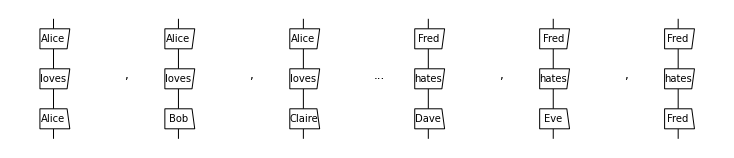

In [3]:
from discopy import Ty, Word, drawing

n = Ty('n')

class SimpleWord(Word):
    """ Word boxes with `dom == cod == n`. """
    def __init__(self, name, dom=n, cod=n, data=None, _dagger=False):
        super().__init__(name, dom=dom, cod=cod, data=data, _dagger=_dagger)

corpus = {
    ' '.join([x, r, y]):
    SimpleWord(x) >> SimpleWord(r) >> SimpleWord(y).dagger()
    for x in E for r in R for y in E}

print("{} subject-verb-object sentences:".format(len(corpus)))
start = drawing.Equation(*list(corpus.values())[:3], symbol=',')
end = drawing.Equation(*list(corpus.values())[-3:], symbol=',')
drawing.equation(start, end, symbol='...', asymmetry=5e-2, figsize=(10, 2), draw_type_labels=False)

In [4]:
import numpy as np; 
np.random.seed(SEED)

from discopy.quantum.optics_vienna import Id, MZI
from discopy.quantum.optics_vienna import Functor

def ansatz(params):
    depth, half_width, _ = params.shape
    chip = Id(2 * half_width)
    for i in range(depth):
        chip >>= Id().tensor(*[
                MZI(*params[i, j]) for j in range(half_width)])\
            if not i % 2 else Id(1).tensor(*[
                MZI(*params[i, j]) for j in range(half_width - 1)]) @ Id(1)
    return chip

In [23]:
n_params = 2 * (depth * width // 2 - depth // 2)

random_params = lambda: np.random.uniform(size=(len(E + R), depth, width // 2, 2))

params0 = random_params()

print("Ansatz for 'Bob' ({} parameters):".format(n_params))

drawing.equation(
    SimpleWord('Bob'), ansatz(params0[1]),
    draw_type_labels=False, symbol='$\\mapsto$', figsize=(10, 4))

print("Total: {} * {} = {} parameters.".format(len(E + R), n_params, len(E + R) * n_params))
print(params0.flatten())

TypeError: <lambda>() got an unexpected keyword argument 'SEED'

Ansatz for 'Alice loves Bob':


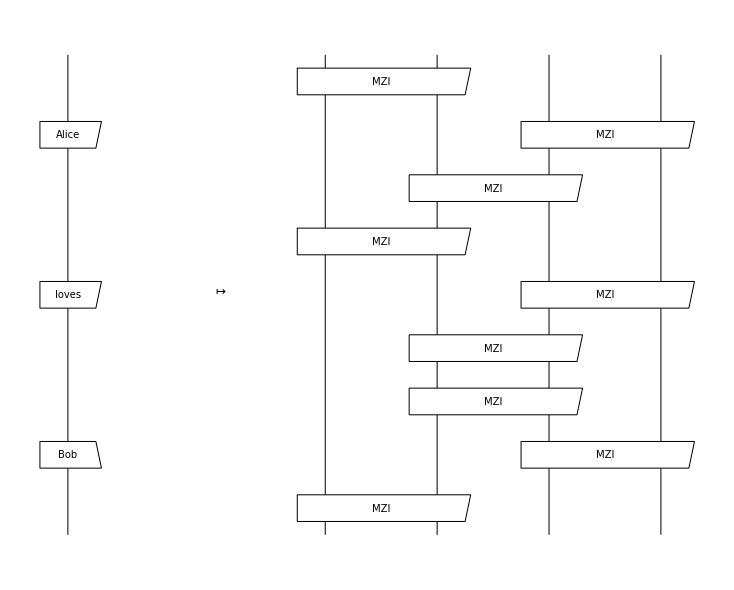

In [6]:
F = lambda params: Functor(
    ob={n: Ty(1) ** width},
    ar={SimpleWord(w): ansatz(params[i]) for i, w in enumerate(E + R)})

F0 = F(params0)

print("Ansatz for 'Alice loves Bob':")
drawing.equation(
    corpus["Alice loves Bob"], F0(corpus["Alice loves Bob"]),
    symbol='$\\mapsto$', figsize=(10, 8), draw_type_labels=False, asymmetry=5e-2)

In [25]:
# probability = lambda amplitude: np.absolute(amplitude) ** 2
activation = lambda x: 1 / (1 + np.exp(-x))
post_processing = lambda x: activation(x * weight + bias)

def evaluate(params, sentence, mode='boson'):
    params = params.reshape(params0.shape)
    if mode=='boson':
        return post_processing(
            F(params)(corpus[sentence]).prob_boson(
                input_modes, output_modes))
    if mode=='distinguish':
        return post_processing(
            F(params)(corpus[sentence]).prob_distinguish(
                input_modes, output_modes))
    if mode=='classical':
        return post_processing(
            F(params)(corpus[sentence]).prob_classical(
                input_modes, output_modes))
    if mode=='coherent':
        return post_processing(
            F(params)(corpus[sentence]).prob_coherent(
                input_modes, output_modes))
    

%time scores = {sentence: evaluate(params0, sentence, mode='coherent') for sentence in corpus}

print("Does Alice love Bob? {} ({:.2F})".format(
    "Yes" if scores["Alice loves Bob"] > .5 else "No", scores["Alice loves Bob"]))

Wall time: 6.78 s
Does Alice love Bob? Yes (0.90)


Min: 0.72 (Eve kills Fred)
Max: 0.98 (Fred hates Alice)
Mean: 0.92
Standard deviation: 0.05

108 true sentences (score > .5)


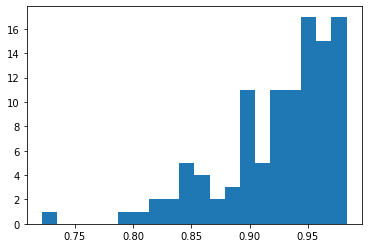

In [9]:
from matplotlib import pyplot as plt

X = list(scores.values())

plt.hist(X, 20)

_min, _max = min(X), max(X)
arg_min, arg_max = list(corpus)[X.index(_min)], list(corpus)[X.index(_max)]

print("Min: {:.2F} ({})".format(_min, arg_min))
print("Max: {:.2F} ({})".format(_max, arg_max))
print("Mean: {:.2F}".format(np.mean(X)))
print("Standard deviation: {:.2F}".format(np.std(X)))
print()
print("{} true sentences (score > .5)".format(sum([x > .5 for x in X])))

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

dataset = {sentence: int(score > .5) for sentence, score in scores.items()}

train, test = train_test_split(list(corpus), test_size=1 / 3, random_state=42)

print("Training set:\n{}\n{}".format('\n'.join(train[:3]), '...\n' if len(train) > 3 else ''))
print("Testing set:\n{}\n{}".format('\n'.join(test[:3]), '...\n' if len(test) > 3 else ''))

Training set:
Bob kills Eve
Claire loves Eve
Alice loves Fred
...

Testing set:
Eve loves Fred
Alice kills Eve
Alice loves Eve
...



In [27]:
def loss(corpus, params, mode='boson'):
    return mean_squared_error(*zip(*[
        (dataset[sentence], evaluate(params, sentence, mode=mode))
        for sentence in corpus]))

testing_loss = lambda params, mode: loss(test, params, mode)
training_loss = lambda params, mode: loss(train, params, mode)

params = random_params().flatten()

for mm in ['boson', 'classical', 'distinguish', 'coherent']:
    print(f'Mode {mm}')
    print("Random initialisation, training_loss: {:.3f}, testing loss: {:.3f}".format(
        training_loss(params, mode=mm), testing_loss(params, mode=mm)))
    print(params)
    print()
    print("Does Alice love Bob?")
    print("Yes" if evaluate(params, 'Alice loves Bob') > .5 else "No")
    print()
    

Mode boson
Random initialisation, training_loss: 0.273, testing loss: 0.302
[0.35444224 0.05481274 0.66760177 ... 0.02085381 0.77722608 0.79060945]

Does Alice love Bob?
No

Mode classical
Random initialisation, training_loss: 0.033, testing loss: 0.067
[0.35444224 0.05481274 0.66760177 ... 0.02085381 0.77722608 0.79060945]

Does Alice love Bob?
No

Mode distinguish
Random initialisation, training_loss: 0.247, testing loss: 0.274
[0.35444224 0.05481274 0.66760177 ... 0.02085381 0.77722608 0.79060945]

Does Alice love Bob?
No

Mode coherent
Random initialisation, training_loss: 0.008, testing loss: 0.029
[0.35444224 0.05481274 0.66760177 ... 0.02085381 0.77722608 0.79060945]

Does Alice love Bob?
No



In [35]:
from noisyopt import minimizeSPSA
from time import time 
import copy

params_boson = copy.deepcopy(params)
params_distinguish = copy.deepcopy(params)
params_classical = copy.deepcopy(params)
params_coherent = copy.deepcopy(params)

training_losses_distinguish, testing_losses_distinguish = [], []
training_losses_classical, testing_losses_classical = [], []
training_losses_coherent, testing_losses_coherent = [], []

In [46]:
# Boson
start = time()

training_losses_boson, testing_losses_boson = [], []

def callback_wrapper(mode='boson', training_losses=[], testing_losses=[]):
    def callback(params):
        training_losses.append(training_loss(params, mode))
        testing_losses.append(testing_loss(params, mode))
        if not len(training_losses) % (n_iter // 10) or len(training_losses) < 10:
            print("Iteration {}, training_loss: {:.3f}, testing loss: {:.3f}".format(
                len(training_losses), training_losses[-1], testing_losses[-1]))
            print(params)
            print()
    return callback
        
result = minimizeSPSA(training_loss, params_boson, args={mode:'boson'}, paired=False, \
    callback=callback_wrapper(mode='boson', training_losses=training_losses_boson, testing_losses=testing_losses_boson), niter=n_iter, a = 0.5, alpha=alpha, c= 0.1, gamma=gamma)

print("Does Alice love Bob?")
print("Yes" if evaluate(result.x, 'Alice loves Bob') > .5 else "No")
print("time taken", time()-start)

Iteration 1, training_loss: 0.279, testing loss: 0.306
[0.28664155 0.02671027 0.64155629 ... 0.07451086 0.7159343  0.75988797]

Iteration 2, training_loss: 0.278, testing loss: 0.306
[0.28398117 0.02937065 0.63889591 ... 0.07185048 0.71859468 0.76254835]

Iteration 3, training_loss: 0.279, testing loss: 0.308
[0.27779081 0.0231803  0.64508626 ... 0.06566012 0.71240432 0.756358  ]

Iteration 4, training_loss: 0.275, testing loss: 0.304
[0.26435064 0.00974013 0.65852643 ... 0.05221996 0.69896415 0.74291783]

Iteration 5, training_loss: 0.278, testing loss: 0.310
[0.25543465 0.00082414 0.64961044 ... 0.04330397 0.70788014 0.75183382]

Iteration 6, training_loss: 0.278, testing loss: 0.309
[ 0.26574812 -0.00948932  0.65992391 ...  0.05361743  0.7181936
  0.74152035]

Iteration 7, training_loss: 0.278, testing loss: 0.307
[ 0.26044771 -0.00418891  0.6546235  ...  0.05891784  0.71289319
  0.74682076]

Iteration 8, training_loss: 0.276, testing loss: 0.307
[ 0.2516413  -0.01299532  0.64581709

KeyboardInterrupt: 

In [14]:
training_losses, testing_losses = [], []
start = time()
def callback(params):
    training_losses.append(training_loss(params))
    testing_losses.append(testing_loss(params))
    if not len(training_losses) % (n_iter // 10) or len(training_losses) < 10:
        print("Iteration {}, training_loss: {:.3f}, testing loss: {:.3f}".format(
            len(training_losses), training_losses[-1], testing_losses[-1]))
        print(params)
        print()

params_boson = copy.deepcopy(params)
result = minimizeSPSA(training_loss, params_boson, paired=False, callback=callback, niter=n_iter, a = 0.5, alpha=alpha, c= 0.1, gamma=gamma)

print("Does Alice love Bob?")
print("Yes" if evaluate(result.x, 'Alice loves Bob') > .5 else "No")
print("time taken", time()-start)

NameError: name 'training_loss' is not defined

In [47]:
training_losses_boson

[0.27904974205687316,
 0.27845824767543603,
 0.2791866663318007,
 0.2745481922114274,
 0.27758207555146114,
 0.2781585675692522,
 0.27795548824436256,
 0.27605875564600874,
 0.2756564110652168,
 0.27572484152942905,
 0.27587676269565786,
 0.27591397858566064,
 0.27712923618589363,
 0.2771837647906286,
 0.2810449033962184,
 0.2812919836585692,
 0.27942356140349944,
 0.27975775743689213,
 0.2797014967016687,
 0.279699743509704,
 0.2794908571152938,
 0.2797799098529702,
 0.2796234022959628,
 0.2794861844721716,
 0.28112260890390645,
 0.2813222981513472,
 0.28233192602584717,
 0.2823469646357773,
 0.2821023098128406,
 0.2823360815402462,
 0.28246898257183944,
 0.28154957674237124,
 0.2816730653817329,
 0.2815905626786994,
 0.28145560149420595]

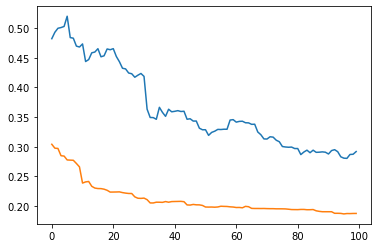

In [19]:
plt.plot(training_losses_coherent)
plt.plot(training_losses)
# plt.plot(testing_losses_coherent)

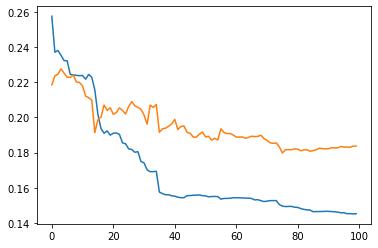

In [15]:
plt.plot(training_losses)
plt.plot(testing_losses)

In [16]:
from sklearn.metrics import classification_report

y_train_true = [dataset[sentence] for sentence in train]
y_train_pred = [evaluate(result.x, sentence) > .5 for sentence in train]

print(classification_report(y_train_true, y_train_pred))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93        48
           1       0.95      0.75      0.84        24

    accuracy                           0.90        72
   macro avg       0.92      0.86      0.88        72
weighted avg       0.91      0.90      0.90        72



In [17]:
y_test_true = [dataset[sentence] for sentence in test]
y_test_pred = [evaluate(result.x, sentence) > .5 for sentence in test]

print(classification_report(y_test_true, y_test_pred))

              precision    recall  f1-score   support

           0       0.84      0.73      0.78        22
           1       0.65      0.79      0.71        14

    accuracy                           0.75        36
   macro avg       0.74      0.76      0.75        36
weighted avg       0.77      0.75      0.75        36



In [18]:
y_true = y_train_true + y_test_true
y_pred = y_train_pred + y_test_pred

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89        70
           1       0.81      0.76      0.78        38

    accuracy                           0.85       108
   macro avg       0.84      0.83      0.84       108
weighted avg       0.85      0.85      0.85       108

